In [1]:
using ITensors
using Plots
using KrylovKit
using LinearAlgebra
using MKL

ITensors.op(::OpName"z", ::SiteType"S=1/2") = [1, 0, 0, -1]
ITensors.op(::OpName"x", ::SiteType"S=1/2") = [0, 1, 1, 0]
ITensors.op(::OpName"n", ::SiteType"S=1/2") = [0, 0, 0, 1]

In [2]:
mutable struct RydbergObserver <: AbstractObserver
    energy_tol::Float64
    last_energy::Float64

    RydbergObserver(energy_tol=0.0) = new(energy_tol, 1000.0)
end

function ITensors.checkdone!(o::RydbergObserver; kwargs...)
    sw = kwargs[:sweep]
    energy = kwargs[:energy]
    if abs(energy - o.last_energy) / abs(energy) < o.energy_tol
        # early stopping
        return true
    end
    o.last_energy = energy
    return false
end

function ITensors.measure!(o::RydbergObserver; kwargs...)
    energy = kwargs[:energy]
    sweep = kwargs[:sweep]
    bond = kwargs[:bond]
    outputlevel = kwargs[:outputlevel]

    # if outputlevel > 0
    #     println("Sweep $sweep at bond $bond, the energy is $energy")
    # end
end

In [122]:
# assume k = 6
function blockade_radius(rabi_f)
    C6 = 1 # Interaction Coefficient for n (quantum number) = 61 (Hz)
    return (C6 / rabi_f)^(1 / 6)
end

function interaction_strength(a, b)
    # C6 = 2 * pi * 275 * 10^9 # Interaction Coefficient for n (quantum number) = 61 (Hz)
    C6 = 1
    lattice_spacing = 1 # lattice constant (micrometers)
    return C6 / (abs(a - b) * lattice_spacing)^6
end

function on_site_detuning(site, N)
    det = 0
    for j = 1:N
        if j != site
            det += interaction_strength(site, j)
        end
    end
    return -0.5 * det
end

function display_mpo_elements(H)
    N = length(H)
    for n = 1:N
        println("Tensor $n of the MPO:")
        println(H[n])
        println("------")
    end
end

function interactions(site)
    os = OpSum()
    for j = 1:site-1
        os += interaction_strength(site, j), "n", site, "n", j
    end
    return os
end

function rydberg(N, rabi_f, delt)
    os = OpSum()
    for site = 1:N
        os -= 0.5 * rabi_f, "x", site
        os -= delt, "n", site
        os += interactions(site)
    end

    # println(combiner(sites)*contract(H))
    # @show H
    # display_mpo_elements(os)

    return os
end

rydberg (generic function with 1 method)

In [123]:
function bipartite_entropy(psi)
    b = Int(ceil(length(psi) / 2))
    # from ITensor docs
    ITensors.orthogonalize!(psi, b)
    U, S, V = svd(psi[b], (linkind(psi, b - 1), siteind(psi, b)))
    SvN = 0.0
    for n in 1:dim(S, 1)
        p = S[n, n]^2
        SvN -= p * log2(p)
    end
    return SvN
end

function ground_state(N, psi0, sites, rabi_f, delt, ed_)
    H = MPO(rydberg(N, rabi_f, delt), sites)

    nsweeps = 30
    # maxdim = [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]
    maxdim = fill(100,nsweeps)
    cutoff = fill(1E-12, nsweeps)

    etol = 1E-12

    obs = RydbergObserver(etol)
    if ed_ == true
        energy, psi = ed(H, psi0, sites)
    end
    if ed_ == false
        energy, psi = dmrg(H, psi0; nsweeps=nsweeps, maxdim=maxdim, cutoff=cutoff, observer=obs, outputlevel=0, println=false)
    end
    # eigen(H, )
    # H2 = inner(H,psi,H,psi)
    # E = inner(psi',H,psi)
    # var = H2-E^2
    # println(E)
    # println(var)
    # println()

    # combin = combiner(sites)
    # println(combin * contract(psi))
    # println(energy)
    entropy = bipartite_entropy(psi)
    return entropy, energy, psi
end

function energy_gap(N, psi0, sites, rabi_f, delt)
    H = MPO(rydberg(N, rabi_f, delt), sites)

    nsweeps = 30
    maxdim = [10, 10, 10, 20, 20, 40, 80, 100, 200, 200]
    cutoff = [1E-12]
    weight = 1E15

    etol = 1E-12

    _, ground_energy, ground_psi = ground_state(N, psi0, sites, rabi_f, delt)

    obs = RydbergObserver(etol)
    energy, excited_psi = dmrg(H, [ground_psi], psi0; nsweeps, maxdim, cutoff, weight=weight, observer=obs)
    gap = energy - ground_energy
    # println(inner(excited_psi, ground_psi))
    return gap
end

function avg_rydberg(psi)
    avgr = 0
    for i = 1:length(psi)
        avgr += expect(psi, "n"; sites=i)
    end
    return avgr / length(psi)
end

function measure_mps(psi)
    measurement = []
    for i = 1:length(psi)
        push!(measurement, round(expect(psi, "n"; sites=i), digits=2))
    end
    return measurement
end

function ed(H, psi0, sites)
    vals, vecs, info = eigsolve(
        contract(H), contract(psi0), 1, :SR; ishermitian=true, tol=1e-20, krylovdim=30, eager=true
    )
    return vals[1], MPS(vecs[1], sites)
end

function dominant_superposition(psi)

end

dominant_superposition (generic function with 1 method)

In [5]:
function frequencies(N, resolution, separation_assumption, start, stop, stop2, psi0, sites)
    V_nn = 1
    C6 = 1 # Interaction Coefficient for n (quantum number) = 61 (Hz)
    a = 1

    # freq = (10 .^ range(start, stop=stop, length=resolution)) .* V_nn
    freq = range(start, stop=stop, length=resolution)

    Y = freq
    X = collect(range(0.0, stop=stop2, length=resolution))

    numbers = zeros(Float64, resolution, resolution)
    # hover_text = Array{String}(undef, length(Y), length(X))
    # numbers = [[0.0 for j in 1:resolution] for i in 1:resolution]
    hover_text = [["" for i in 1:resolution] for j in 1:resolution]

    for i = 1:length(Y)
        for j = 1:length(X)
            if ((i - 1) * length(X) + j) % 200 == 0
                println((i - 1) * length(X) + j)
            end
            rabi_freq = C6/((a * Y[i])^6)
            entropy, energy, gs = ground_state(N, psi0, sites, rabi_freq, X[j] * rabi_freq)
            numbers[i, j] = avg_rydberg(gs)
            mps_state = measure_mps(gs)
            hover_text[i][j] = join(string.(mps_state), ", ")
            # hover_text[i][j] = string(numbers[i, j])
        end
    end

    # println(hover_text)
    # println(numbers)

    # Y = sort(((Y .^ (-1 / 6)) .* C6^(1 / 6)) ./ a)
    # numbers = reverse(numbers)
    # hover_text = reverse(hover_text)

    # Y = log2.(Y)

    deltaX = (maximum(X) - minimum(X)) / length(X)
    deltaY = (maximum(Y) - minimum(Y)) / length(Y)

    # Adjust the plot limits to ensure cells are not cut off
    adjusted_xlims = (minimum(X) - 0.5 * deltaX, maximum(X) + 0.5 * deltaX)
    adjusted_ylims = (minimum(Y) - 0.5 * deltaY, maximum(Y) + 0.5 * deltaY)

    # return heatmap(numbers, color=:viridis, title="Heatmap")
    return heatmap(
        X, Y, numbers,
        # xlims=adjusted_xlims,
        # ylims=adjusted_ylims,
        hover=hover_text,
        color=:viridis,
        aspect_ratio=:auto,
        xlabel="Δ/Ω",
        ylabel="R_b/a",
        colorbar_title="Average Number in Rydberg"
    )
end

frequencies (generic function with 1 method)

In [124]:
function stand(N, resolution, coarse, separation_assumption, start, stop, stop2, psi0, sites, ed_=true)
    V_nn = 2 * pi * 60 * (10^6)
    V_nn = 1
    C6 = 1 # Interaction Coefficient for n (quantum number) = 61 (Hz)
    a = 1

    # freq = (10 .^ range(start, stop=stop, length=resolution)) .* V_nn
    freq = range(start, stop=stop, length=resolution)

    Y = freq

    X = collect(range(0.0, stop=stop2, length=resolution))

    entropies = zeros(Float64, resolution, resolution)
    hover_text = [["" for i in 1:resolution] for j in 1:resolution]

    coarse_size = round(Int64, resolution/coarse)
    psi0_arr = Array{MPS}(undef, coarse_size, coarse_size)

    for i in 1:coarse
        for j in 1:coarse
            println("initializing psi0s")
            resolution_i = round(Int64, (i*2-1) / (coarse*2) * resolution)
            resolution_j = round(Int64, (j*2-1) / (coarse*2) * resolution)
            rabi_freq = C6/((a * Y[resolution_i])^6)
            delta = X[resolution_j] * rabi_freq
            psi0_arr[i, j] = ground_state(N, psi0, sites, rabi_freq, delta, true)[3]
        end
    end

    for i = 1:length(Y)
        for j = 1:length(X)
            # println((i - 1) * length(X) + j)
            if ((i - 1) * length(X) + j) % 50 == 0
                println((i - 1) * length(X) + j)
            end

            coarse_i = floor(Int64, ((i-1) / coarse_size) + 1)
            coarse_j = floor(Int64, ((j-1) / coarse_size) + 1)
            psi0 = psi0_arr[coarse_i, coarse_j]
            
            # rabi_freq = (Y[i]*a / (C6^(1/6)))^(-6)
            rabi_freq = C6/((a * Y[i])^6)
            # println(Y[i])
            # rabi_freq = Y[length(Y)-i+1]

            entropy, energy, gs = ground_state(N, psi0, sites, rabi_freq, X[j] * rabi_freq, ed_)
            entropies[i, j] = entropy
            mps_state = measure_mps(gs)
            hover_text[i][j] = join(string.(mps_state), ", ")
        end
    end

    # Y = sort(((Y .^ (-1 / 6)) .* C6^(1 / 6)) ./ a)
    # Y = log2.(Y)

    deltaX = (maximum(X) - minimum(X)) / length(X)
    deltaY = (maximum(Y) - minimum(Y)) / length(Y)

    # Adjust the plot limits to ensure cells are not cut off
    adjusted_xlims = (minimum(X) - 0.5 * deltaX, maximum(X) + 0.5 * deltaX)
    adjusted_ylims = (minimum(Y) - 0.5 * deltaY, maximum(Y) + 0.5 * deltaY)

    return heatmap(
        X, Y, entropies,
        # xlims=adjusted_xlims,
        # ylims=adjusted_ylims,
        hover=hover_text,
        color=:viridis,
        aspect_ratio=:auto,
        xlabel="Δ/Ω",
        ylabel="R_b/a",
        colorbar_title="Bipartite Entropy"
    )
end


stand (generic function with 3 methods)

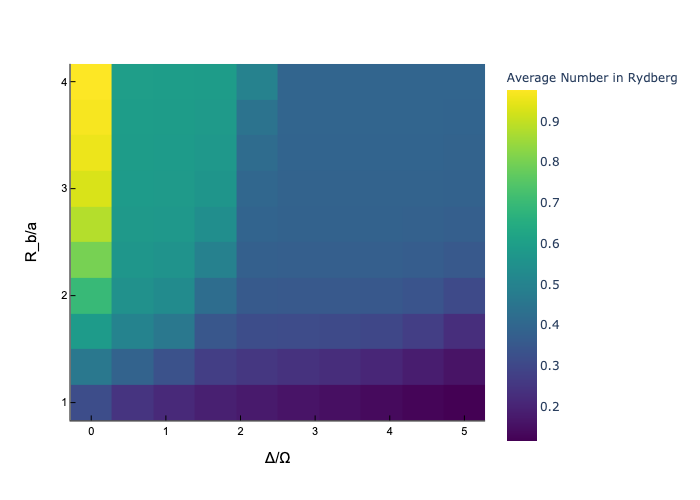

In [341]:
plotlyjs()
N=5
resolution=10
separation_assumption=2
sites = siteinds("S=1/2", N)
psi0 = MPS(sites, ["Dn" for i = 1:N])
psi0 = randomMPS(sites; linkdims=50)
plot(frequencies(N, resolution, separation_assumption, 1, 4, 5, psi0, sites))

1


2


3


4


5


6


7


8


9


10
10


11


12


13


14


15


16


17


18


19


20
20


21


22


23


24


25


26


27


28


29


30
30


31


32


33


34


35


36


37


38


39


40
40


41


42


43


44


45


46


47


48


49


50
50


51


52


53


54


55


56


57


58


59


60
60


61


62


63


64


65


66


67


68


69


70
70


71


72


73


74


75


76


77


78


79


80
80


81


82


83


84


85


86


87


88


89


90
90


91


92


93


94


95


96


97


98


99


100
100


101


102


103


104


105


106


107


108


109


110
110


111


112


113


114


115


116


117


118


119


120
120


121


122


123


124


125


126


127


128


129


130
130


131


132


133


134


135


136


137


138


139


140
140


141


142


143


144


145


146


147


148


149


150
150


151


152


153


154


155


156


157


158


159


160
160


161


162


163


164


165


166


167


168


169


170
170


171


172


173


174


175


176


177


178


179


180
180


181


182


183


184


185


186


187


188


189


190
190


191


192


193


194


195


196


197


198


199


200
200


201


202


203


204


205


206


207


208


209


210
210


211


212


213


214


215


216


217


218


219


220
220


221


222


223


224


225


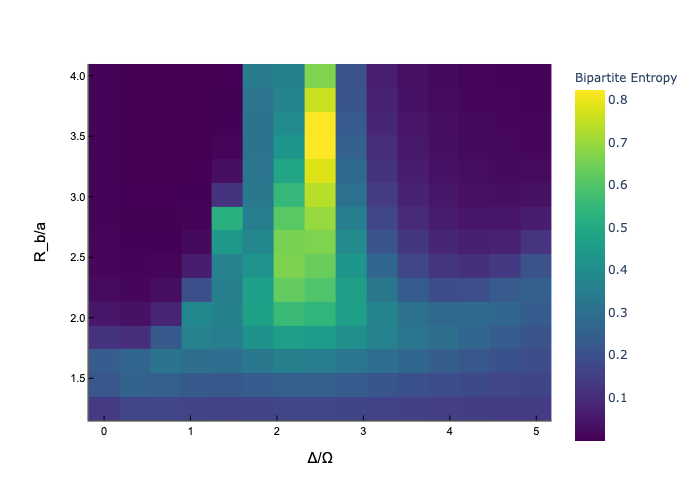

In [7]:
ITensors.disable_warn_order()
plotlyjs()
N=9
resolution=15
separation_assumption=2
sites = siteinds("S=1/2", N)
psi0 = MPS(sites, ["Dn" for i = 1:N])
# psi0 = randomMPS(sites; linkdims=50)
plot(stand(N, resolution, separation_assumption, 1.25, 4, 5, psi0, sites, true))

50


100


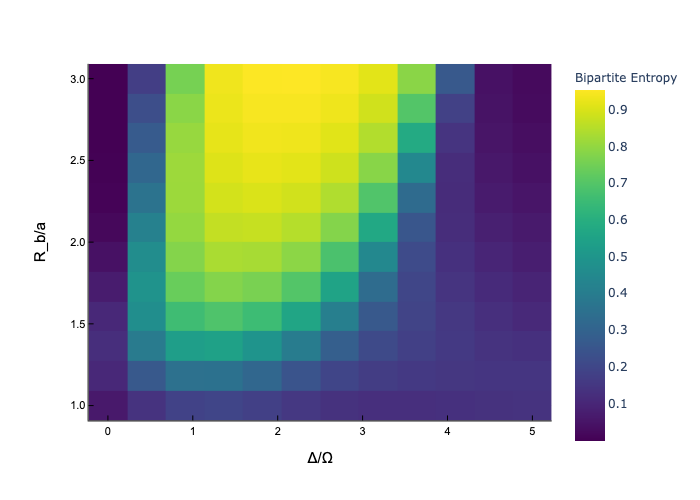

In [33]:
plotlyjs()
N=6
resolution=12
separation_assumption=2
sites = siteinds("S=1/2", N)
psi0 = MPS(sites, ["Dn" for i = 1:N])
# psi0 = randomMPS(sites; linkdims=50)
plot(stand(N, resolution, separation_assumption, 1, 3, 5, psi0, sites, true))

50


100


150


200


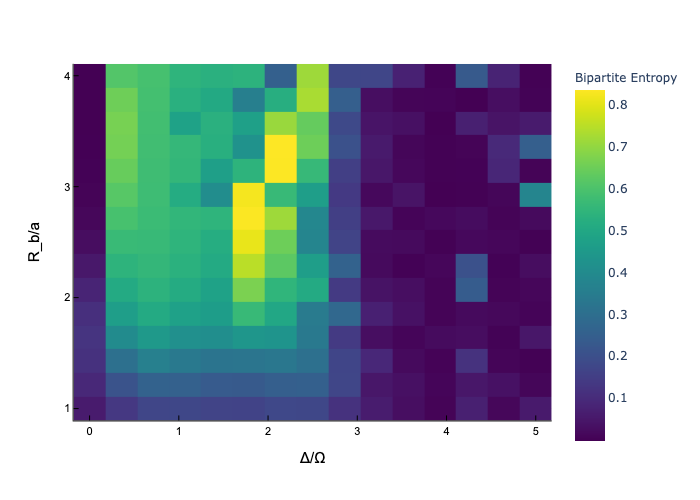

In [120]:
plotlyjs()
N=12
resolution=15
coarse_resolution=3
separation_assumption=2
sites = siteinds("S=1/2", N)
psi0 = MPS(sites, ["Dn" for i = 1:N])
plot(stand(N, resolution, coarse_resolution, separation_assumption, 1, 4, 5, psi0, sites, false))

50


100


150


200


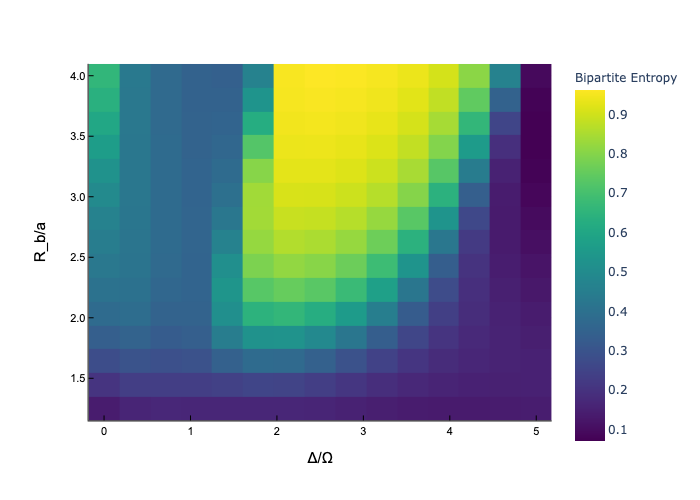

In [75]:
plotlyjs()
N=8
resolution=15
separation_assumption=2
sites = siteinds("S=1/2", N)
psi0 = MPS(sites, ["Dn" for i = 1:N])
# psi0 = randomMPS(sites; linkdims=50)
plot(stand(N, resolution, separation_assumption, 1.25, 4.0, 5, psi0, sites, true))

50


100


150


200


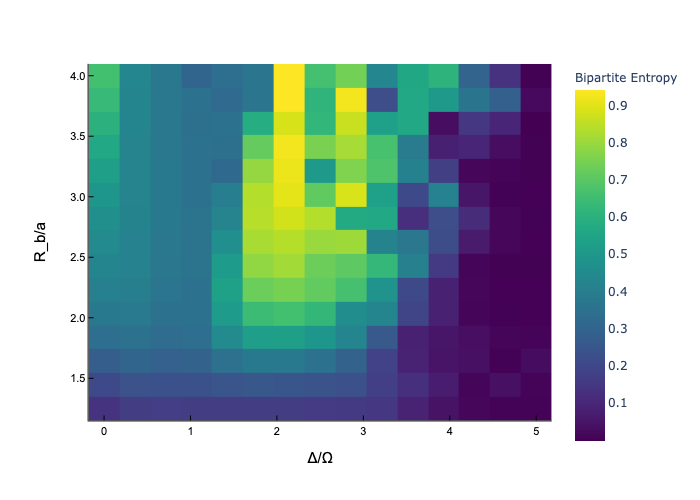

In [76]:
plotlyjs()
N=8
resolution=15
separation_assumption=2
sites = siteinds("S=1/2", N)
psi0 = MPS(sites, ["Dn" for i = 1:N])
# psi0 = randomMPS(sites; linkdims=50)
plot(stand(N, resolution, separation_assumption, 1.25, 4.0, 5, psi0, sites, false))

50


100


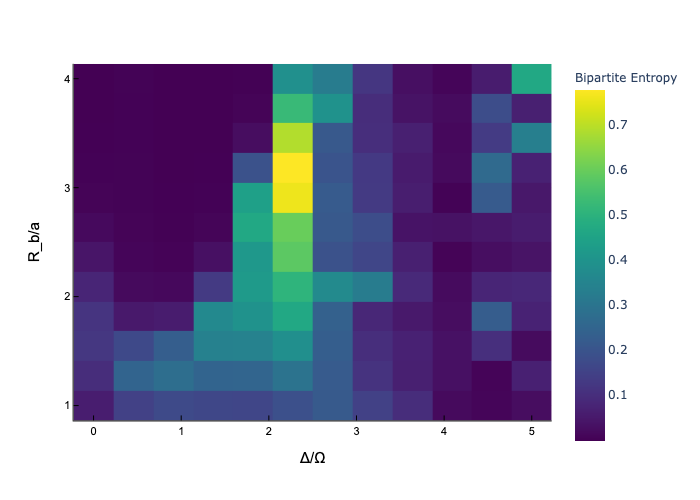

In [45]:
plotlyjs()
N=9
resolution=12
separation_assumption=2
sites = siteinds("S=1/2", N)
psi0 = MPS(sites, ["Dn" for i = 1:N])
# psi0 = randomMPS(sites; linkdims=50)
plot(stand(N, resolution, separation_assumption, 1, 4, 5, psi0, sites, false))

50


100


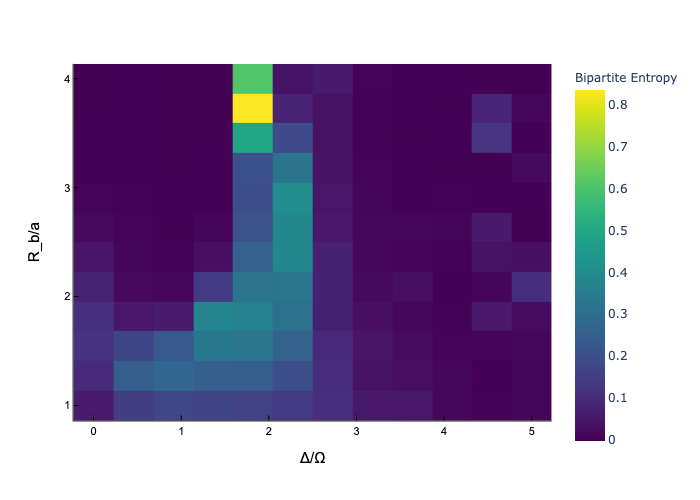

In [39]:
plotlyjs()
N=9
resolution=12
separation_assumption=2
sites = siteinds("S=1/2", N)
psi0 = MPS(sites, [i%2==0 ? "Dn" : "Up" for i = 1:N])
# psi0 = randomMPS(sites; linkdims=50)
plot(stand(N, resolution, separation_assumption, 1, 4, 5, psi0, sites, false))

50


100


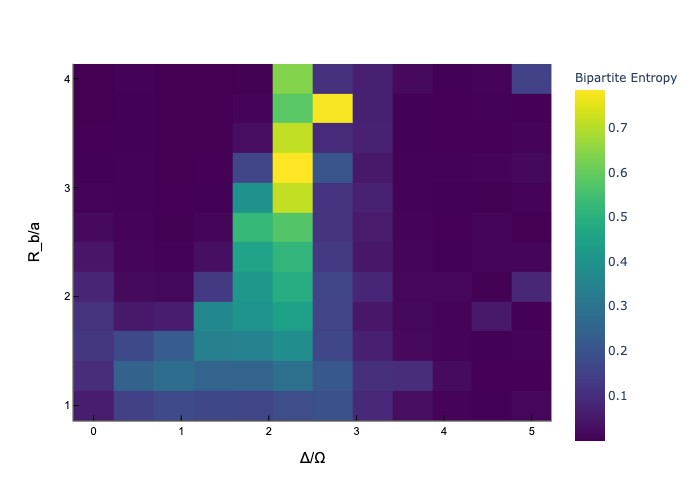

In [40]:
plotlyjs()
N=9
resolution=12
separation_assumption=2
sites = siteinds("S=1/2", N)
psi0 = MPS(sites, [i%2==0 ? "Up" : "Dn" for i = 1:N])
# psi0 = randomMPS(sites; linkdims=50)
plot(stand(N, resolution, separation_assumption, 1, 4, 5, psi0, sites, false))

50


100


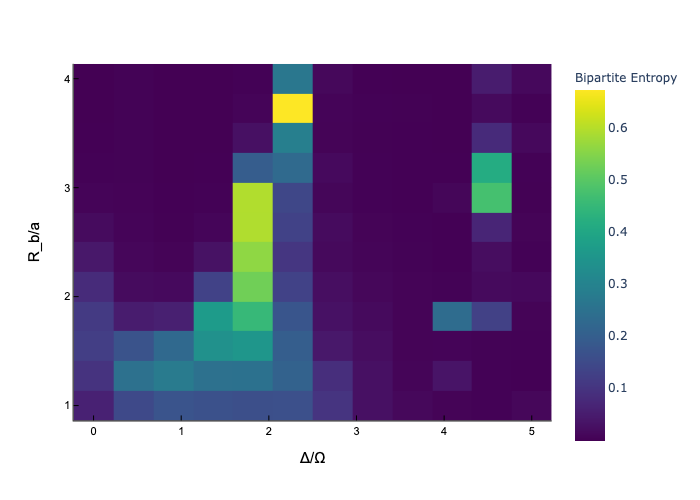

In [41]:
plotlyjs()
N=9
resolution=12
separation_assumption=2
sites = siteinds("S=1/2", N)
psi0 = MPS(sites, [i%3==0 ? "Up" : "Dn" for i = 1:N])
# psi0 = randomMPS(sites; linkdims=50)
plot(stand(N, resolution, separation_assumption, 1, 4, 5, psi0, sites, false))

50


100


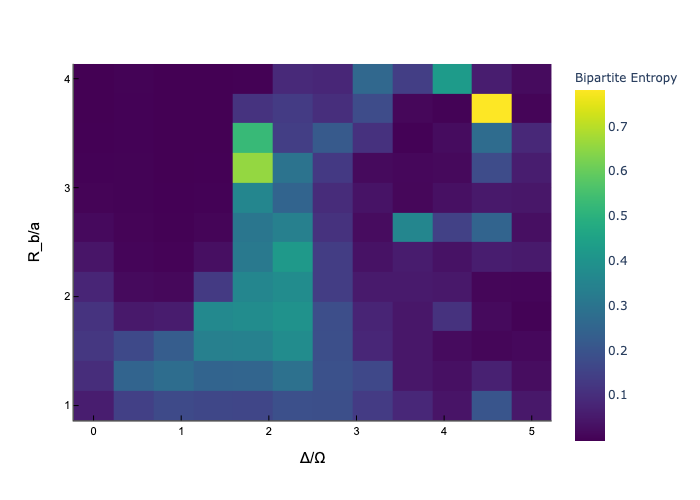

In [42]:
plotlyjs()
N=9
resolution=12
separation_assumption=2
sites = siteinds("S=1/2", N)
psi0 = MPS(sites, [i%3==0 ? "Dn" : "Up" for i = 1:N])
# psi0 = randomMPS(sites; linkdims=50)
plot(stand(N, resolution, separation_assumption, 1, 4, 5, psi0, sites, false))